## Utils

In [1]:
def show_gray(img,title=""):
  """
  Function to show grayscale image
  """
  plt.imshow(img,cmap='gray')
  plt.title(title)

## Download the Dataset

In [2]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1Z73UHw9IS492qxHvNUiB7-DidVl_ePfg'
destination = '/content/dataset.zip'
download_file_from_google_drive(file_id, destination)

FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset.zip'

In [ ]:
!unzip -q dataset.zip
!rm -rf dataset.zip

# Metrics


In [6]:
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

def MSE(image1,image2):
  """ 
  Mean Squared Error
  :param image1: image1
  :param image2: image2
  :rtype: float
  :return: MSE value
  """

  # Calculating the Mean Squared Error
  mse = np.mean(np.square(image1.astype(np.float64) - image2.astype(np.float64)))
  
  return mse

def PSNR(image1, image2, peak=255):
  """ 
  Peak signal-to-noise ratio
  :param image1: image1
  :param image2: image2
  :param peak: max value of pixel 8-bit image (255)
  :rtype: float
  :return: PSNR value
  """

  # Calculating the Mean Squared Error
  mse = MSE(image1,image2)

  # Calculating the Peak Signal Noise Ratio
  psnr = 10*np.log10(peak**2/mse)

  return psnr

In [7]:
#@title Grader { vertical-output: true }
seed =  200#@param {type:"integer"}
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

np.random.seed(seed)
image1 = np.random.randint(0,256,(1280,720,3))
image2 = np.random.randint(0,256,(1280,720,3))

print(f"Skimage -> PSNR: {peak_signal_noise_ratio(image1,image2,data_range=255):.4f} | MSR: {mean_squared_error(image1,image2):.4f}")
print(f"My Func -> PSNR: {PSNR(image1,image2):.4f} | MSR: {MSE(image1,image2):.4f}")

Skimage -> PSNR: 7.7475 | MSR: 10922.7525
My Func -> PSNR: 7.7475 | MSR: 10922.7525


# Creating Noisy Images

## Salt n Pepper Noise
you can read about this more [here](https://en.wikipedia.org/wiki/Salt-and-pepper_noise).

## Gaussian Noise
you can read about this more [here](https://en.wikipedia.org/wiki/Gaussian_noise). 

In [11]:
from skimage.util import random_noise
import numpy as np

class noisy_system():
  def example(self,img,**kwargs):
    """
    An example function to test expected return.
    You can read more about skimage.util.random_noise at https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.random_noise
    """
    noisy_image = random_noise(img,**kwargs)
    noisy_image = np.uint8(noisy_image*255)
    return noisy_image

  def create_salt_and_pepper_noise(self,img,amount=0.05):
    """
    function to create salt and pepper noise
    :param image: input image
    :rtype: uint8 (w,h)
    :return: noisy image
    
    """

    # Converting pixel values from 0-255 to 0-1 float
    img = img/255

    # Getting the dimensions of the image
    h = img.shape[0]
    w = img.shape[1]

    # Setting the ratio of salt and pepper in salt and pepper noised image
    s = 0.5
    p = 0.5

    # Initializing the result (noisy) image
    result = img.copy()

    # Adding salt noise to the image
    salt = np.ceil(amount * img.size * s)
    vec = []
    for i in img.shape:
      vec.append(np.random.randint(0, i-1, int(salt)))
    
    result[vec] = 1

    # Adding pepper noise to the image
    pepper = np.ceil(amount * img.size * p)
    vec = []
    for i in img.shape:
      vec.append(np.random.randint(0, i-1, int(salt)))
    
    result[vec] = 0

    # Converting the result back to uint8
    result = np.uint8(result*255)

    return result

  def create_gaussian_noise(self,img,mean=0,var=0.01):
    """
    function to create gaussian noise
    :param image: input image
    :rtype: uint8 (w,h)
    :return: noisy image
    """

    # Converting pixel values from 0-255 to 0-1 float
    img = img/255

    # Initializing the result (noisy) image
    result = img.copy()

    # Adding gaussian noise to the image
    gauss = np.random.normal(mean, var**0.5, img.shape)
    result = result + gauss
    result = np.clip(result, 0, 1)

    # Converting the result back to uint8
    result = np.uint8(result*255)

    return result

Total Time taken: 0.02s

Statistics:
Example   => SNP -> PSNR: 18.11 | MSE: 1004.83
Example   => GSN -> PSNR: 20.49 | MSE: 581.30
My Func   => SNP -> PSNR: 5.69 | MSE: 17544.87
My Func   => GSN -> PSNR: 20.48 | MSE: 582.81


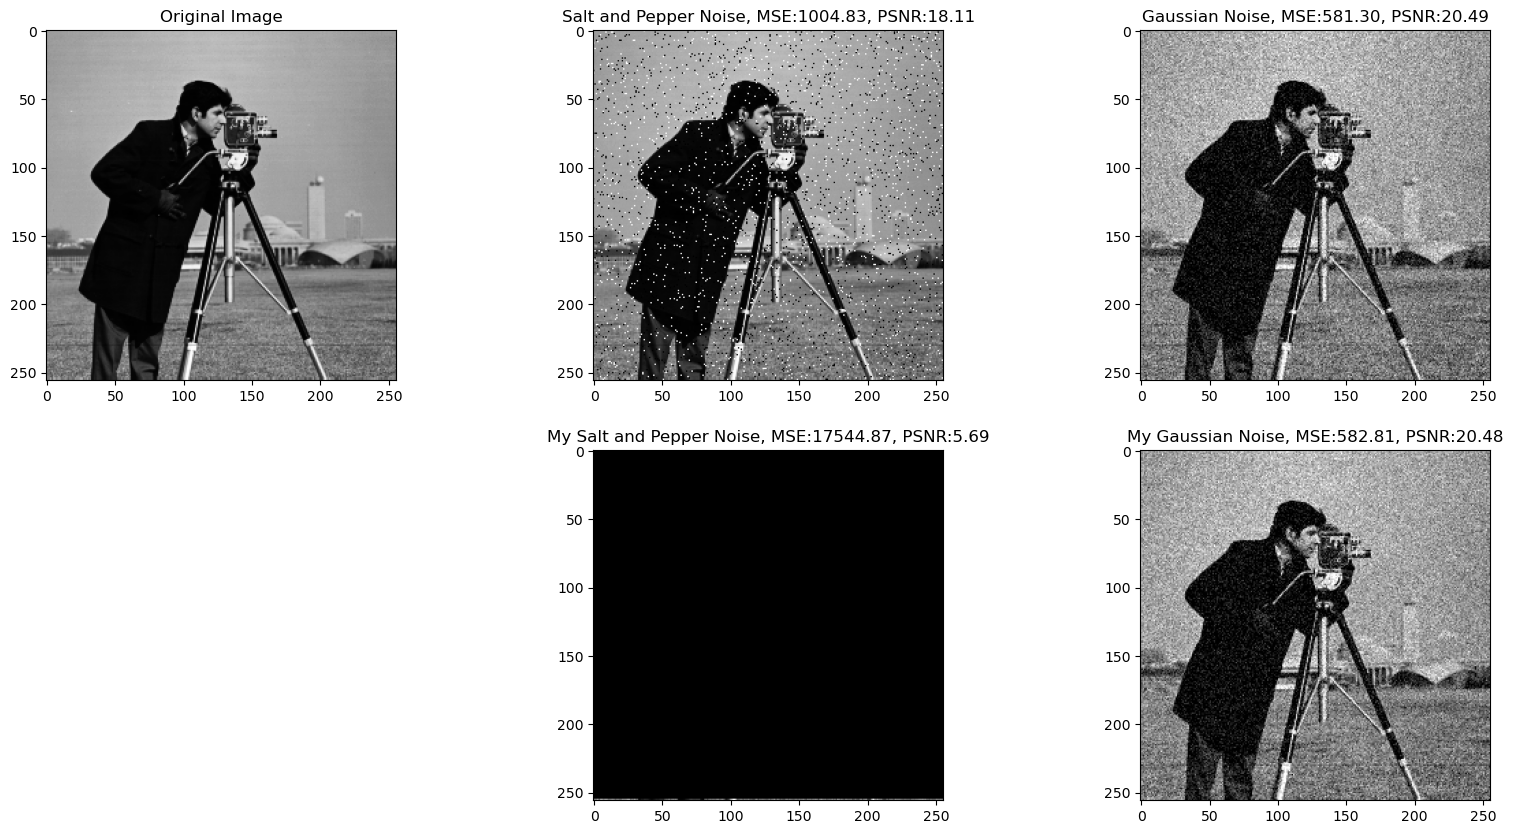

In [13]:
#@title Grader { vertical-output: true, display-mode: "form" }
image_number = 3 #@param {type:"slider", min:1, max:10, step:1}
# %%timeit 
%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

clear_output(wait=True)

start = time.time()

noise_maker               = noisy_system()
image                     = cv2.imread(f"Dataset/Image{image_number}.png")
image                     = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

salt_and_pepper_example   = noise_maker.example(image.copy(),mode="s&p")
gaussian_example          = noise_maker.example(image.copy(),mode="gaussian")
salt_and_pepper_image     = noise_maker.create_salt_and_pepper_noise(image.copy())
gaussian_image            = noise_maker.create_gaussian_noise(image.copy())

end = time.time()
print(f"Total Time taken: {end-start:.2f}s\n")
print("Statistics:")
print(f"Example   => SNP -> PSNR: {PSNR(salt_and_pepper_example,image):.2f} | MSE: {MSE(salt_and_pepper_example,image):.2f}")
print(f"Example   => GSN -> PSNR: {PSNR(gaussian_example,image):.2f} | MSE: {MSE(gaussian_example,image):.2f}")
print(f"My Func   => SNP -> PSNR: {PSNR(salt_and_pepper_image,image):.2f} | MSE: {MSE(salt_and_pepper_image,image):.2f}")
print(f"My Func   => GSN -> PSNR: {PSNR(gaussian_image,image):.2f} | MSE: {MSE(gaussian_image,image):.2f}")


plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
show_gray(image,"Original Image")
plt.subplot(2,3,2)
show_gray(salt_and_pepper_example,
          f"Salt and Pepper Noise, MSE:{MSE(image,salt_and_pepper_example):.2f}, PSNR:{PSNR(image,salt_and_pepper_example):.2f}")
plt.subplot(2,3,3)
show_gray(gaussian_example,
          f"Gaussian Noise, MSE:{MSE(image,gaussian_example):.2f}, PSNR:{PSNR(image,gaussian_example):.2f}")
plt.subplot(2,3,5)
show_gray(salt_and_pepper_image,
          f"My Salt and Pepper Noise, MSE:{MSE(image,salt_and_pepper_image):.2f}, PSNR:{PSNR(image,salt_and_pepper_image):.2f}")
plt.subplot(2,3,6)
show_gray(gaussian_image,
          f"My Gaussian Noise, MSE:{MSE(image,gaussian_image):.2f}, PSNR:{PSNR(image,gaussian_image):.2f}")
plt.show()

# Non Local Means

In [15]:
from numba import jit

# Function to preprocess neighbors (small_window x small_window) for each pixel
@jit(nopython=True, cache=True)
def findAllNeighbors(padImg,small_window,big_window,h,w):
    # Finding width of the neighbor window and padded image from the center pixel
    smallWidth = small_window//2
    bigWidth = big_window//2

    # Initializing the result
    neighbors = np.zeros((padImg.shape[0],padImg.shape[1],small_window,small_window))

    # Finding the neighbors of each pixel in the original image using the padded image
    for i in range(bigWidth,bigWidth + h):
        for j in range(bigWidth,bigWidth + w):   
            neighbors[i,j] = padImg[(i - smallWidth):(i + smallWidth + 1) , (j - smallWidth):(j + smallWidth + 1)]
    
    return neighbors

# Function to calculate the weighted average value (Ip) for each pixel
@jit(nopython=True, cache=True)
def evaluateNorm(pixelWindow, neighborWindow, Nw):
    # Initialize numerator and denominator of Ip (Ip = Ip_Numerator/Z)
    Ip_Numerator,Z = 0,0

    # Calculating Ip for pixel p using neighborood pixels q
    for i in range(neighborWindow.shape[0]):
      for j in range(neighborWindow.shape[1]):
        # (small_window x small_window) array for pixel q
        q_window = neighborWindow[i,j]

        # Coordinates of pixel q
        q_x,q_y = q_window.shape[0]//2,q_window.shape[1]//2

        # Iq value
        Iq = q_window[q_x, q_y]

        # Norm of Ip - Iq
        w = np.exp(-1*((np.sum((pixelWindow - q_window)**2))/Nw))

        # Calculating Ip
        Ip_Numerator = Ip_Numerator + (w*Iq)
        Z = Z + w

    return Ip_Numerator/Z

In [16]:
class NLMeans():
  """
  Non Local Means, donot change the solve function. You may add any other class 
  functions or other functions in the colab file. but refrain for function/class
  definitions already given. These will be used to grade later on.
  """
  def example(self,img,**kwargs):
    denoised_image = cv2.fastNlMeansDenoising(img,**kwargs)
    return denoised_image

  def solve(self,img,h=30,small_window=7,big_window=21):
    """
    Solve function to perform nlmeans filtering.

    :param img: noisy image
    :param h: sigma h (as mentioned in the paper)
    :param small_window: size of small window
    :param big_window: size of big window
    :rtype: uint8 (w,h)
    :return: solved image
    """

    # Padding the original image with reflect mode
    padImg = np.pad(img,big_window//2,mode='reflect')

    return self.NLM(padImg,img,h,small_window,big_window)

  @staticmethod
  @jit(nopython = True, cache = True)
  def NLM(padImg, img, h, small_window, big_window):
    # Calculating neighborhood window
    Nw = (h**2)*(small_window**2)

    # Getting dimensions of the image
    h,w = img.shape

    # Initializing the result
    result = np.zeros(img.shape)

    # Finding width of the neighbor window and padded image from the center pixel
    bigWidth = big_window//2
    smallWidth = small_window//2

    # Preprocessing the neighbors of each pixel
    neighbors = findAllNeighbors(padImg, small_window, big_window, h, w) 

    # NL Means algorithm
    for i in range(bigWidth, bigWidth + h):
        for j in range(bigWidth, bigWidth + w):
            # (small_window x small_window) array for pixel p
            pixelWindow = neighbors[i,j]

            # (big_window x big_window) pixel neighborhhod array for pixel p
            neighborWindow = neighbors[(i - bigWidth):(i + bigWidth + 1) , (j - bigWidth):(j + bigWidth + 1)]

            # Calculating Ip using pixelWindow and neighborWindow
            Ip = evaluateNorm(pixelWindow, neighborWindow, Nw)

            # Cliping the pixel values to stay between 0-255 
            result[i - bigWidth, j - bigWidth] = max(min(255, Ip), 0)

    return result

(Inbuilt) Time taken: 0.24s

(My function) Time taken: 14.46s

Statistics:
salt_and_paper_h: 36 , gaussian_h: 27

Noisy   => SNP -> PSNR: 18.03 | MSE: 1022.98
Noisy   => GSN -> PSNR: 20.49 | MSE: 580.52
Skimage => SNP -> PSNR: 24.91 | MSE: 209.98
Skimage => GSN -> PSNR: 27.28 | MSE: 121.70
My Func => SNP -> PSNR: 24.94 | MSE: 208.57
My Func => GSN -> PSNR: 27.30 | MSE: 121.16



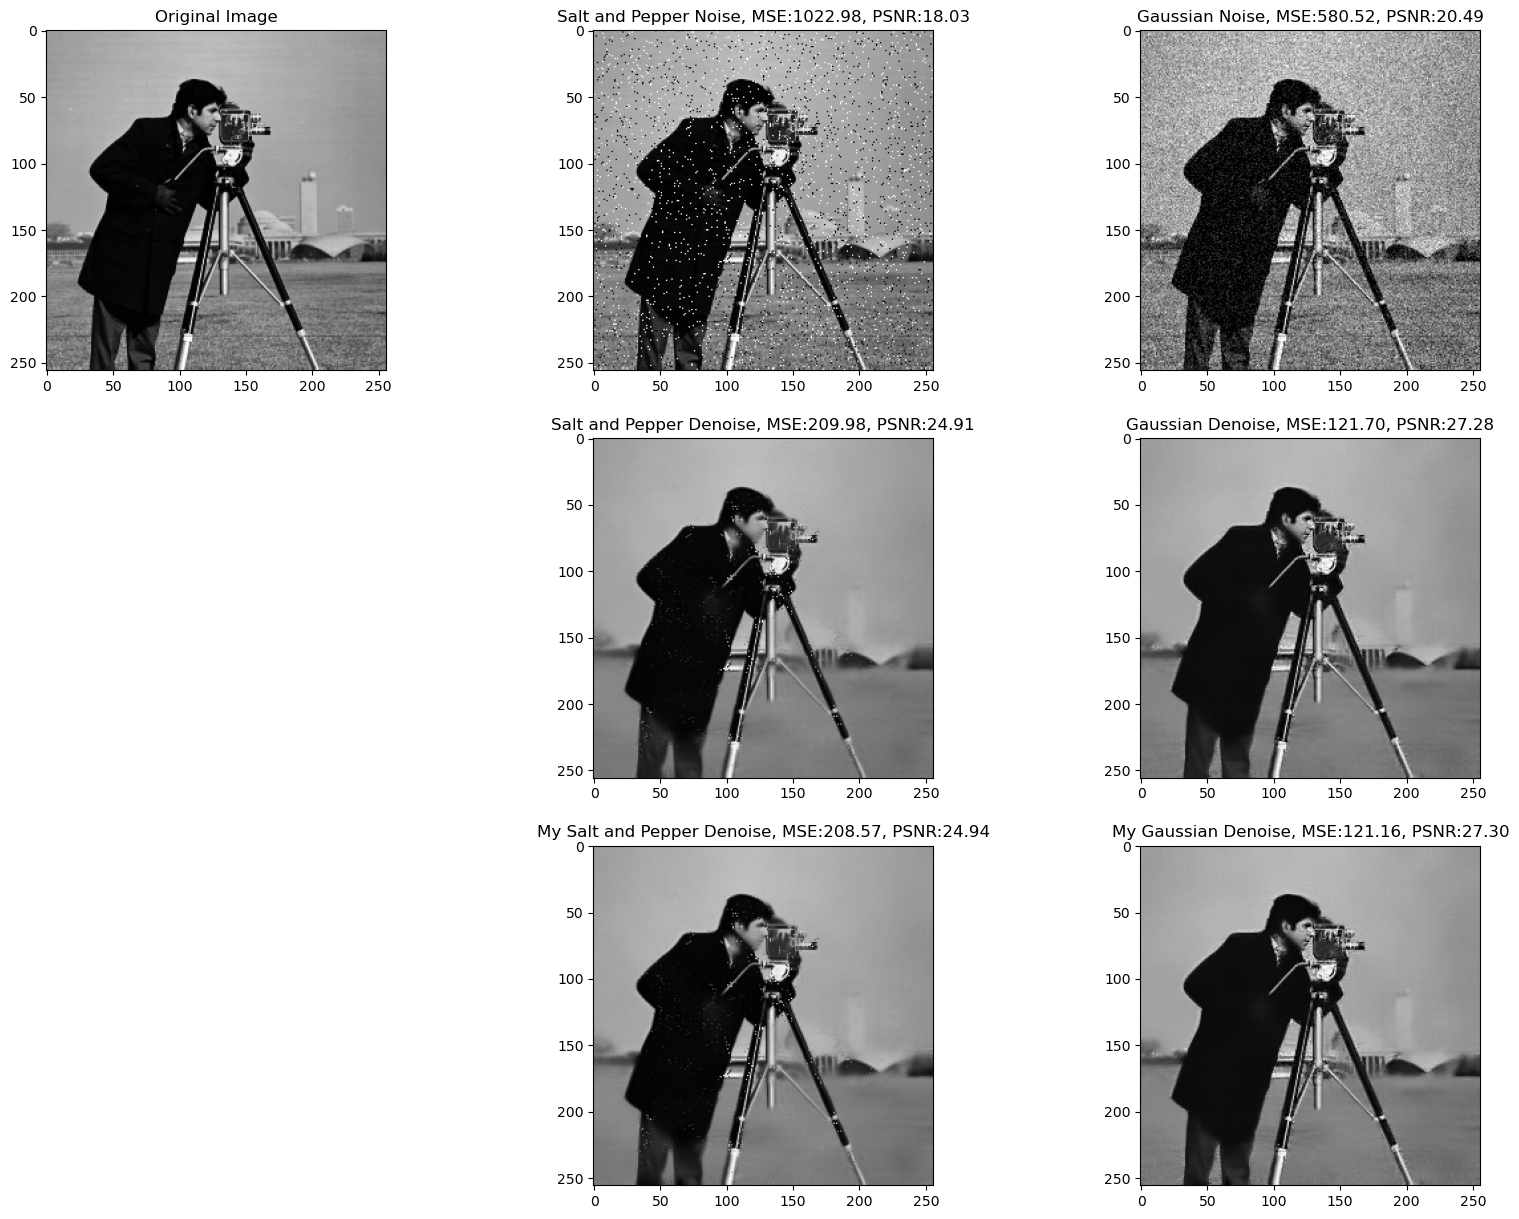

In [19]:
#@title Grader { vertical-output: true, display-mode: "form" }
image_number = 3 #@param {type:"slider", min:1, max:10, step:1}
salt_and_paper_h =   36#@param {type:"integer"}
gaussian_h =         27#@param {type:"integer"}

# %%timeit 
%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
 
clear_output(wait=True)
 
 
denoiser                    = NLMeans()
image                       = cv2.imread(f"Dataset/Image{image_number}.png")
image                       = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
salt_and_pepper_example     = noise_maker.example(image.copy(),mode="s&p")
gaussian_example            = noise_maker.example(image.copy(),mode="gaussian")
 
start = time.time()
 
salt_and_pepper_denoise     = denoiser.example(salt_and_pepper_example.copy(),h=salt_and_paper_h)
gaussian_denoise            = denoiser.example(gaussian_example.copy(),h=gaussian_h)
 
end = time.time()
print(f"(Inbuilt) Time taken: {end-start:.2f}s\n")
 
start = time.time()
 
my_salt_and_pepper_denoise  = denoiser.solve(salt_and_pepper_example.copy(),h=salt_and_paper_h)
my_gaussian_denoise         = denoiser.solve(gaussian_example.copy(),h=gaussian_h)
 
end = time.time()
print(f"(My function) Time taken: {end-start:.2f}s\n")
 
print("Statistics:")
print(f"salt_and_paper_h: {salt_and_paper_h} , gaussian_h: {gaussian_h}\n")
print(f"Noisy   => SNP -> PSNR: {PSNR(salt_and_pepper_example,image):.2f} | MSE: {MSE(salt_and_pepper_example,image):.2f}")
print(f"Noisy   => GSN -> PSNR: {PSNR(gaussian_example,image):.2f} | MSE: {MSE(gaussian_example,image):.2f}")
print(f"Skimage => SNP -> PSNR: {PSNR(salt_and_pepper_denoise,image):.2f} | MSE: {MSE(salt_and_pepper_denoise,image):.2f}")
print(f"Skimage => GSN -> PSNR: {PSNR(gaussian_denoise,image):.2f} | MSE: {MSE(gaussian_denoise,image):.2f}")
print(f"My Func => SNP -> PSNR: {PSNR(my_salt_and_pepper_denoise,image):.2f} | MSE: {MSE(my_salt_and_pepper_denoise,image):.2f}")
print(f"My Func => GSN -> PSNR: {PSNR(my_gaussian_denoise,image):.2f} | MSE: {MSE(my_gaussian_denoise,image):.2f}\n")
 
plt.figure(figsize=(20,15))
plt.subplot(3,3,1)
show_gray(image,"Original Image")
plt.subplot(3,3,2)
show_gray(salt_and_pepper_example,
          f"Salt and Pepper Noise, MSE:{MSE(image,salt_and_pepper_example):.2f}, PSNR:{PSNR(image,salt_and_pepper_example):.2f}")
plt.subplot(3,3,3)
show_gray(gaussian_example,
          f"Gaussian Noise, MSE:{MSE(image,gaussian_example):.2f}, PSNR:{PSNR(image,gaussian_example):.2f}")
plt.subplot(3,3,5)
show_gray(salt_and_pepper_denoise,
          f"Salt and Pepper Denoise, MSE:{MSE(image,salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,6)
show_gray(gaussian_denoise,
          f"Gaussian Denoise, MSE:{MSE(image,gaussian_denoise):.2f}, PSNR:{PSNR(image,gaussian_denoise):.2f}")
plt.subplot(3,3,8)
show_gray(my_salt_and_pepper_denoise,
          f"My Salt and Pepper Denoise, MSE:{MSE(image,my_salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,my_salt_and_pepper_denoise):.2f}")
plt.subplot(3,3,9)
show_gray(my_gaussian_denoise,
          f"My Gaussian Denoise, MSE:{MSE(image,my_gaussian_denoise):.2f}, PSNR:{PSNR(image,my_gaussian_denoise):.2f}")
plt.show()

# Gaussian Filtering Comparison

In [20]:
class GaussianFilter():
  """
  GaussianFilter, donot change the solve function. You may add any other class 
  functions or other functions in the colab file. but refrain for function/class
  definitions already given. These will be used to grade later on.
  """

  def solve(self, img, ksize=(5,5), sigma_x=0):
    """
    Solve function to perform gaussian filtering.

    :param img: noisy image
    :param ksize: representing the size of the kernel.
    :param sigma_x: standard deviation in X direction
    :rtype: uint8 (w,h)
    :return: solved image
    """

    # Applying Gaussian Filtering on the noisy image 
    result = cv2.GaussianBlur(img,ksize,sigma_x,cv2.BORDER_DEFAULT) 

    return result

(Inbuilt) Time taken (Skimage): 0.26s

(Inbuilt) Time taken (Gaussian Blur): 0.00s

(My function) Time taken: 12.51s

Statistics:
salt_and_paper_h: 36 , gaussian_h: 27

Noisy   => SNP -> PSNR: 18.02 | MSE: 1025.85
Noisy   => GSN -> PSNR: 20.47 | MSE: 584.17
Skimage => SNP -> PSNR: 24.92 | MSE: 209.47
Skimage => GSN -> PSNR: 27.28 | MSE: 121.73
My Func => SNP -> PSNR: 24.94 | MSE: 208.64
My Func => GSN -> PSNR: 27.29 | MSE: 121.30

Gaussian Filter => SNP -> PSNR: 23.59 | MSE: 284.50
Gaussian Filter => GSN -> PSNR: 24.23 | MSE: 245.62


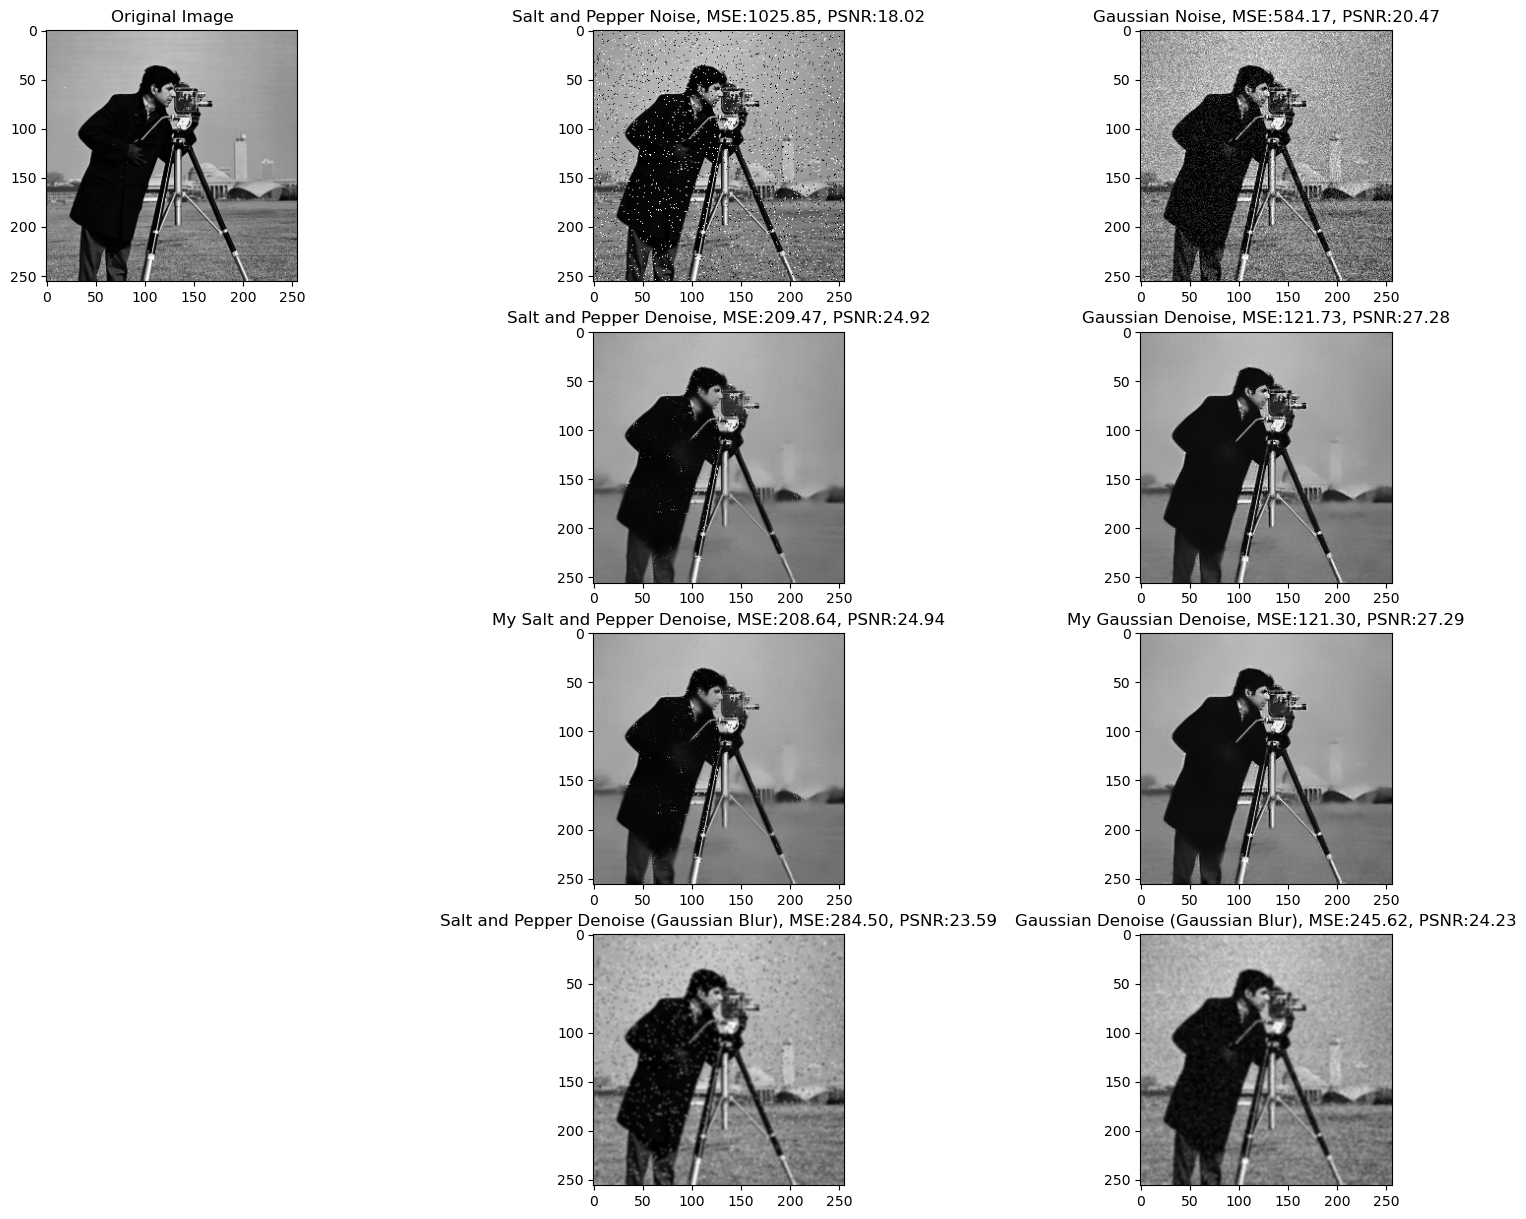

In [22]:
#@title Grader { vertical-output: true, display-mode: "form" }
image_number = 3 #@param {type:"slider", min:1, max:10, step:1}
salt_and_paper_h =   36#@param {type:"integer"}
gaussian_h =         27#@param {type:"integer"}

# %%timeit 
%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
 
clear_output(wait=True)
 
 
denoiser                    = NLMeans()
image                       = cv2.imread(f"Dataset/Image{image_number}.png")
image                       = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
salt_and_pepper_example     = noise_maker.example(image.copy(),mode="s&p")
gaussian_example            = noise_maker.example(image.copy(),mode="gaussian")
 
start = time.time()
 
salt_and_pepper_denoise     = denoiser.example(salt_and_pepper_example.copy(),h=salt_and_paper_h)
gaussian_denoise            = denoiser.example(gaussian_example.copy(),h=gaussian_h)
 
end = time.time()
print(f"(Inbuilt) Time taken (Skimage): {end-start:.2f}s\n")

Gauss                       = GaussianFilter()

start = time.time()
 
salt_and_pepper_gauss     = Gauss.solve(salt_and_pepper_example.copy())
gaussian_gauss            = Gauss.solve(gaussian_example.copy())

end = time.time()
print(f"(Inbuilt) Time taken (Gaussian Blur): {end-start:.2f}s\n")
 
start = time.time()
 
my_salt_and_pepper_denoise  = denoiser.solve(salt_and_pepper_example.copy(),h=salt_and_paper_h)
my_gaussian_denoise         = denoiser.solve(gaussian_example.copy(),h=gaussian_h)
 
end = time.time()
print(f"(My function) Time taken: {end-start:.2f}s\n")
 
print("Statistics:")
print(f"salt_and_paper_h: {salt_and_paper_h} , gaussian_h: {gaussian_h}\n")
print(f"Noisy   => SNP -> PSNR: {PSNR(salt_and_pepper_example,image):.2f} | MSE: {MSE(salt_and_pepper_example,image):.2f}")
print(f"Noisy   => GSN -> PSNR: {PSNR(gaussian_example,image):.2f} | MSE: {MSE(gaussian_example,image):.2f}")
print(f"Skimage => SNP -> PSNR: {PSNR(salt_and_pepper_denoise,image):.2f} | MSE: {MSE(salt_and_pepper_denoise,image):.2f}")
print(f"Skimage => GSN -> PSNR: {PSNR(gaussian_denoise,image):.2f} | MSE: {MSE(gaussian_denoise,image):.2f}")
print(f"My Func => SNP -> PSNR: {PSNR(my_salt_and_pepper_denoise,image):.2f} | MSE: {MSE(my_salt_and_pepper_denoise,image):.2f}")
print(f"My Func => GSN -> PSNR: {PSNR(my_gaussian_denoise,image):.2f} | MSE: {MSE(my_gaussian_denoise,image):.2f}\n")
print(f"Gaussian Filter => SNP -> PSNR: {PSNR(salt_and_pepper_gauss,image):.2f} | MSE: {MSE(salt_and_pepper_gauss,image):.2f}")
print(f"Gaussian Filter => GSN -> PSNR: {PSNR(gaussian_gauss,image):.2f} | MSE: {MSE(gaussian_gauss,image):.2f}")
 

plt.figure(figsize=(20,15))
plt.subplot(4,3,1)
show_gray(image,"Original Image")
plt.subplot(4,3,2)
show_gray(salt_and_pepper_example,
          f"Salt and Pepper Noise, MSE:{MSE(image,salt_and_pepper_example):.2f}, PSNR:{PSNR(image,salt_and_pepper_example):.2f}")
plt.subplot(4,3,3)
show_gray(gaussian_example,
          f"Gaussian Noise, MSE:{MSE(image,gaussian_example):.2f}, PSNR:{PSNR(image,gaussian_example):.2f}")
plt.subplot(4,3,5)
show_gray(salt_and_pepper_denoise,
          f"Salt and Pepper Denoise, MSE:{MSE(image,salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,salt_and_pepper_denoise):.2f}")
plt.subplot(4,3,6)
show_gray(gaussian_denoise,
          f"Gaussian Denoise, MSE:{MSE(image,gaussian_denoise):.2f}, PSNR:{PSNR(image,gaussian_denoise):.2f}")
plt.subplot(4,3,8)
show_gray(my_salt_and_pepper_denoise,
          f"My Salt and Pepper Denoise, MSE:{MSE(image,my_salt_and_pepper_denoise):.2f}, PSNR:{PSNR(image,my_salt_and_pepper_denoise):.2f}")
plt.subplot(4,3,9)
show_gray(my_gaussian_denoise,
          f"My Gaussian Denoise, MSE:{MSE(image,my_gaussian_denoise):.2f}, PSNR:{PSNR(image,my_gaussian_denoise):.2f}")
plt.subplot(4,3,11)
show_gray(salt_and_pepper_gauss,
          f"Salt and Pepper Denoise (Gaussian Blur), MSE:{MSE(image,salt_and_pepper_gauss):.2f}, PSNR:{PSNR(image,salt_and_pepper_gauss):.2f}")
plt.subplot(4,3,12)
show_gray(gaussian_gauss,
          f"Gaussian Denoise (Gaussian Blur), MSE:{MSE(image,gaussian_gauss):.2f}, PSNR:{PSNR(image,gaussian_gauss):.2f}")
plt.show()